In [1]:
!pip install yfinance
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.9 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293632 sha256=8ae41bd76b557af17de71a3c033f413d3d29664491b5d7273fefdf476593378c
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [9]:
import yfinance as yf
import pandas as pd

symbol = 'GOOGL'
data = yf.download(symbol, start='2014-01-01', end='2024-01-01')
original_data = data.copy()

[*********************100%***********************]  1 of 1 completed


# EDA of the Set

In [12]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,27.914413,27.971722,27.734234,27.855856,27.823923,72783144
2014-01-03,27.902903,27.951200,27.650902,27.652653,27.620953,66601332
2014-01-06,27.853104,27.999498,27.688688,27.960960,27.928907,70701228
2014-01-07,28.153152,28.520771,28.057056,28.500000,28.467329,102001896
2014-01-08,28.678679,28.711712,28.360611,28.559309,28.526569,89610300


In [16]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


(2516, 6)

In [14]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,69.128416,69.857553,68.412124,69.153132,69.073856,3.776601e+07
std,36.613651,37.058593,36.199115,36.633037,36.591042,1.997012e+07
min,24.962000,25.014000,24.545500,24.853001,24.824511,9.312000e+06
25%,38.519625,38.917376,38.215877,38.526752,38.482587,2.608750e+07
50%,57.159500,57.644251,56.565250,57.222250,57.156652,3.225400e+07
75%,99.480000,101.070002,98.105001,99.970001,99.855400,4.246545e+07
max,151.250000,151.546494,148.899002,149.838501,149.666733,2.571620e+08


array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Adj Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

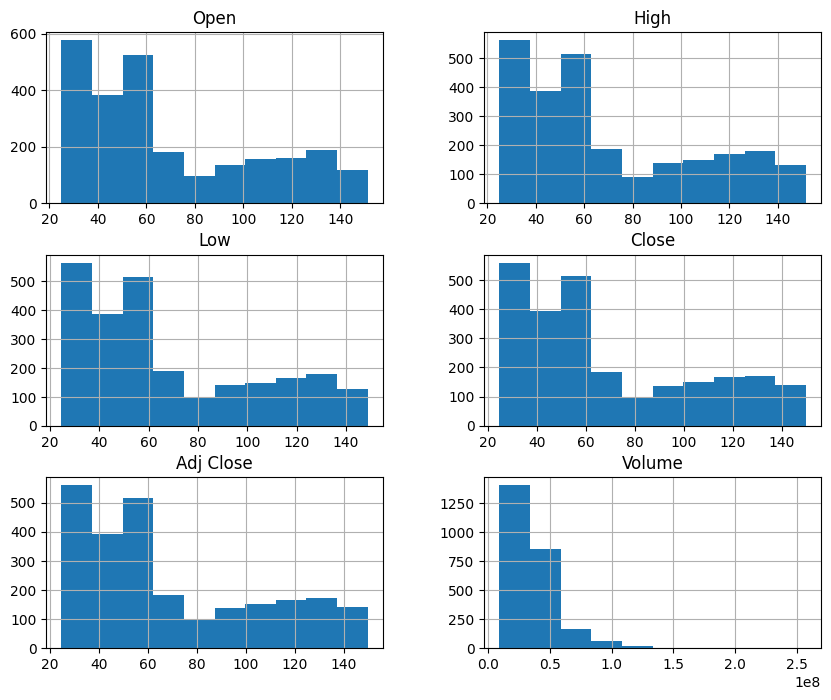

In [17]:
data.hist(figsize=(10, 8))

## Calculating Technical Indicators

In [22]:
def calculate_RSI(df, window=14):
    delta    = df['Close'].diff(1)
    gain     = delta.where(delta > 0, 0)
    loss     = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs       = avg_gain / avg_loss
    rsi      = 100 - (100 / (1 + rs))
    return rsi

def calculate_MACD(df, short_window=12, long_window=26, signal_window=9):
    short_ema   = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema    = df['Close'].ewm(span=long_window, adjust=False).mean()
    macd        = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

data.loc[:, 'MA_10']  = data['Close'].rolling(window=10).mean()
data.loc[:, 'MA_50']  = data['Close'].rolling(window=50).mean()

data.loc[:, 'RSI_14'] = calculate_RSI(data, window=14)

data.loc[:, 'MACD'], data.loc[:, 'Signal_Line'] = calculate_MACD(data)

data['Daily_Return']  = data['Close'].pct_change()

# Calculate volatility as rolling standard deviation of daily returns
data['Volatility_10'] = data['Daily_Return'].rolling(window=10).std() * (252**0.5)  
data['Volatility_50'] = data['Daily_Return'].rolling(window=50).std() * (252**0.5) 

### Drop the ones with no value of calculated indicator

In [23]:
features = ['Close','MA_10', 'MA_50', 'RSI_14', 'MACD', 'Signal_Line', 'Volatility_10', 'Volatility_50']
target   = 'Close'

data_cleaned = data.dropna(subset = features)

print(data_cleaned.shape)

(2466, 14)


### Splitting the Dataset

In [46]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_cleaned, test_size=0.2, shuffle=False, random_state=42)

test_data.head()

,Open,High,Low,Close,Adj Close,Volume,MA_10,MA_50,RSI_14,MACD,Signal_Line,Daily_Return,Volatility_10,Volatility_50
Date,,,,,,,,,,,,,,
2022-01-12,141.149994,142.608002,140.694504,141.430496,141.268356,26108000,141.281898,145.069709,35.402814,-1.523993,-0.992399,0.012126,0.263229,0.219991
2022-01-13,141.539993,142.850006,138.408997,138.587006,138.428131,31436000,140.520549,144.932800,28.549322,-1.636701,-1.121259,-0.020105,0.276045,0.222161
2022-01-14,137.078995,140.742004,136.998505,139.480499,139.320602,29662000,139.983398,144.790450,28.192432,-1.635077,-1.224023,0.006447,0.280810,0.221866
2022-01-18,136.175003,137.131500,135.438507,135.998001,135.842102,34872000,139.084048,144.545060,25.236285,-1.892978,-1.357814,-0.024968,0.298550,0.226477
2022-01-19,136.523499,137.959503,135.015503,135.116501,134.961609,28648000,138.155748,144.270349,24.280561,-2.143783,-1.515008,-0.006482,0.298312,0.226368


## Visualization of Indicators

This is done to understand and get a grasp of the dataset

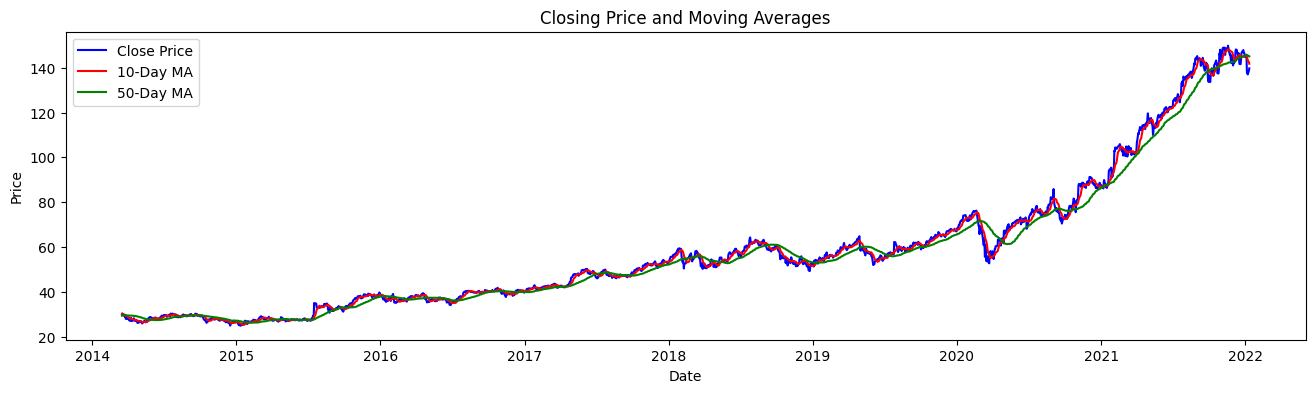

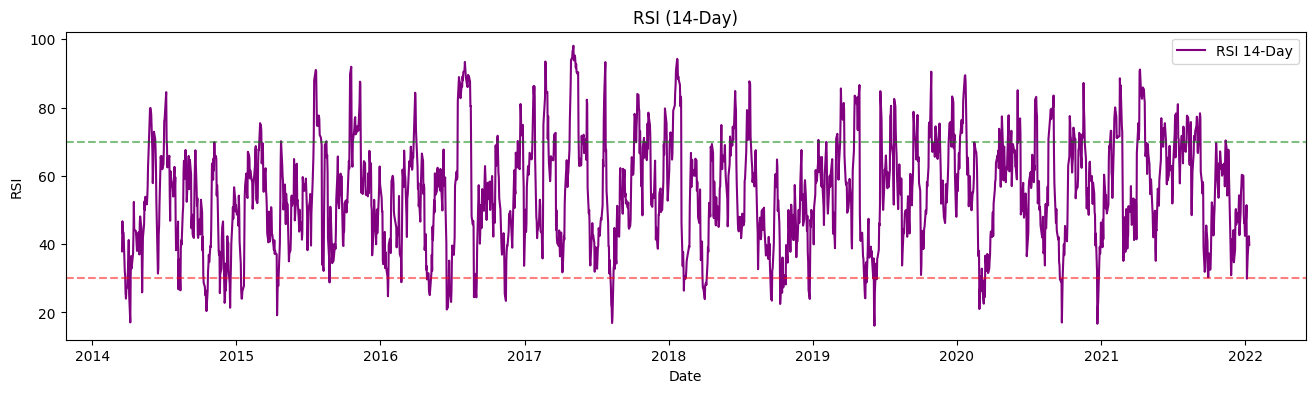

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))
plt.plot(train_data.index, train_data['Close'], label='Close Price', color='blue')
plt.plot(train_data.index, train_data['MA_10'], label='10-Day MA', color='red')
plt.plot(train_data.index, train_data['MA_50'], label='50-Day MA', color='green')
plt.title('Closing Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(16,4))
plt.plot(train_data.index, train_data['RSI_14'], label='RSI 14-Day', color='purple')
plt.axhline(30, linestyle='--', alpha=0.5, color='red')  # Oversold level
plt.axhline(70, linestyle='--', alpha=0.5, color='green')  # Overbought level
plt.title('RSI (14-Day)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend(loc='best')
plt.show()

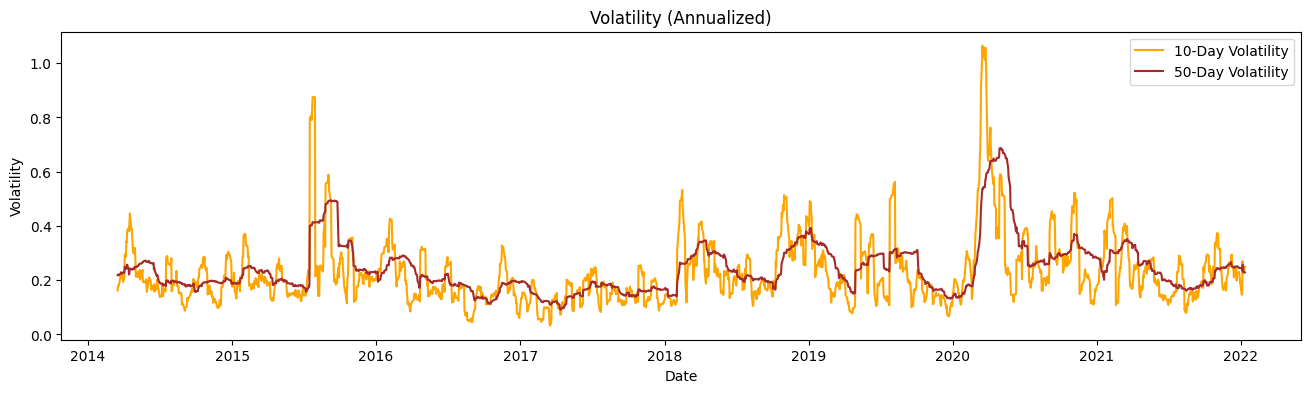

In [26]:
plt.figure(figsize=(16,4))
plt.plot(train_data.index, train_data['Volatility_10'], label='10-Day Volatility', color='orange')
plt.plot(train_data.index, train_data['Volatility_50'], label='50-Day Volatility', color='brown')
plt.title('Volatility (Annualized)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(loc='best')
plt.show()

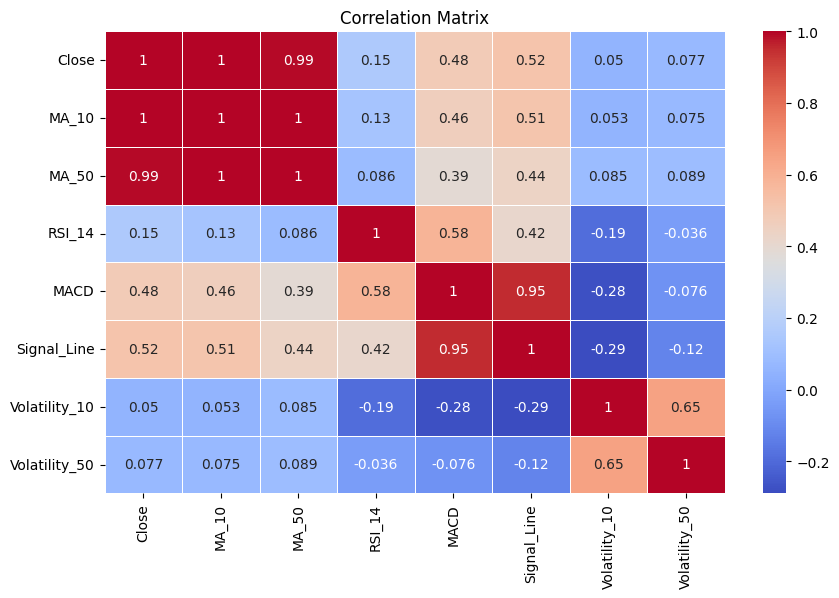

In [27]:
import seaborn as sns

corr_matrix = train_data[['Close', 'MA_10', 'MA_50', 'RSI_14', 'MACD', 'Signal_Line', 'Volatility_10', 'Volatility_50']].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

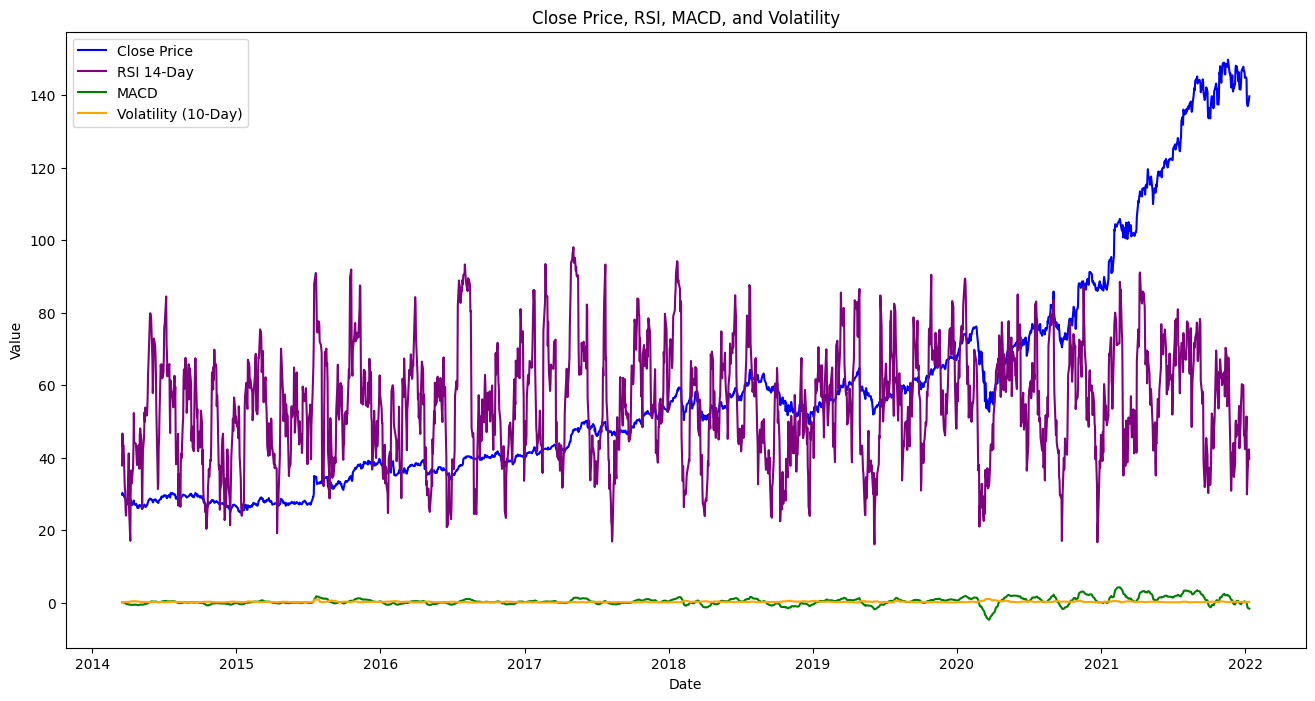

In [28]:
plt.figure(figsize=(16,8))
plt.plot(train_data.index, train_data['Close'], label='Close Price', color='blue')
plt.plot(train_data.index, train_data['RSI_14'], label='RSI 14-Day', color='purple')
plt.plot(train_data.index, train_data['MACD'], label='MACD', color='green')
plt.plot(train_data.index, train_data['Volatility_10'], label='Volatility (10-Day)', color='orange')
plt.title('Close Price, RSI, MACD, and Volatility')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()

# Preprocessing The Data

In [39]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

scaler              = MinMaxScaler()
target_scaler       = MinMaxScaler()

train_data_scaled   = scaler.fit_transform(train_data[features])
test_data_scaled    = scaler.transform(test_data[features])

train_target_scaled = target_scaler.fit_transform(train_data[[target]])
test_target_scaled  = target_scaler.transform(test_data[[target]])

train_data_scaled   = np.array(train_data_scaled)
train_target_scaled = np.array(train_target_scaled)

test_data_scaled    = np.array(test_data_scaled)
test_target_scaled  = np.array(test_data_scaled)

def create_sequences(data, target, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append((data[i:i+seq_length], target[i+seq_length]))
    return sequences

seq_length      = 50

train_sequences = create_sequences(train_data_scaled, train_target_scaled, seq_length)

test_sequences  = create_sequences(test_data_scaled, test_target_scaled, seq_length)

train_sequences = [(torch.Tensor(x), torch.Tensor(y)) for x, y in train_sequences]
test_sequences  = [(torch.Tensor(x), torch.Tensor(y)) for x, y in test_sequences]

# Training and Evaluation

## Creating an LSTM model

In [40]:
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1  = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2  = nn.Linear(hidden_size // 2, output_size)
    
    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 50).to(x.device)  
        c_0 = torch.zeros(2, x.size(0), 50).to(x.device)
        
        lstm_out, _ = self.lstm(x, (h_0, c_0)) 
        
        out = self.fc1(lstm_out[:, -1, :])
        out = self.fc2(out)
        return out


## Wandb, Loss_fn, Optimizer, and Scheduler

In [42]:
import wandb
from kaggle_secrets import UserSecretsClient
from torch.optim.lr_scheduler import CosineAnnealingLR;

secret_label      = 'BULLWANDB_KEY'
secret_value      = UserSecretsClient().get_secret(secret_label)
wandb.login(key   = secret_value)
wandb.init(project="BullTech-Task2", config={
    "learning_rate": 5e-5,
    "epochs": 100,
    "batch_size": 32,
    "hidden_size": 50,
    "num_layers": 2,
    "architecture": "LSTM"
})

input_size  = len(features)
hidden_size = 50  
num_layers  = 2
output_size = 1

model = StockLSTM(input_size, hidden_size, num_layers, output_size)
model.to(device)

loss_function = nn.MSELoss()
optimizer     = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler     = CosineAnnealingLR(optimizer, T_max=100)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


## Training the Model

In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Early Stopping
patience          = 10
best_loss         = float('inf')
epochs_no_improve = 0


def train_model_with_early_stopping(model, train_sequences, loss_function, optimizer, scheduler, epochs=100, patience=10):
    global best_loss, epochs_no_improve
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        all_predictions = []
        all_targets = []
        
        for seq, target in train_sequences:
            optimizer.zero_grad()
            
            seq = seq.unsqueeze(0).to(device)
            target = target.to(device)
            
            output = model(seq)
            loss = loss_function(output, target)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            all_predictions.append(output.item())
            all_targets.append(target.item())
        
        scheduler.step()
        
        # Wand Logging
        avg_loss = total_loss / len(train_sequences)
        mse      = mean_squared_error(all_targets, all_predictions)
        rmse     = np.sqrt(mse)
        mae      = mean_absolute_error(all_targets, all_predictions)
        wandb.log({
            "train/loss": avg_loss,
            "train/learning_rate": scheduler.get_last_lr()[0],
            "train/RMSE": rmse,
            "train/MAE": mae,
            "epoch": epoch + 1
        })
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, LR: {scheduler.get_last_lr()[0]:.8f}')
        
        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0 
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best Loss: {best_loss:.4f}")
            break 

train_model_with_early_stopping(model, train_sequences, loss_function, optimizer, scheduler, epochs=100, patience=10)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 0.0005, RMSE: 0.0217, MAE: 0.0153, LR: 0.000050


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/100, Loss: 0.0051, RMSE: 0.0711, MAE: 0.0292, LR: 0.000050


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 3/100, Loss: 0.0031, RMSE: 0.0556, MAE: 0.0239, LR: 0.000050


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 4/100, Loss: 0.0015, RMSE: 0.0383, MAE: 0.0172, LR: 0.000050


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5/100, Loss: 0.0007, RMSE: 0.0271, MAE: 0.0144, LR: 0.000050


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 6/100, Loss: 0.0005, RMSE: 0.0219, MAE: 0.0133, LR: 0.000050


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 7/100, Loss: 0.0004, RMSE: 0.0198, MAE: 0.0129, LR: 0.000049


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 8/100, Loss: 0.0004, RMSE: 0.0193, MAE: 0.0129, LR: 0.000049


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 9/100, Loss: 0.0004, RMSE: 0.0197, MAE: 0.0133, LR: 0.000049


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/100, Loss: 0.0004, RMSE: 0.0203, MAE: 0.0139, LR: 0.000049


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 11/100, Loss: 0.0004, RMSE: 0.0205, MAE: 0.0142, LR: 0.000049


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 12/100, Loss: 0.0004, RMSE: 0.0203, MAE: 0.0142, LR: 0.000048


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 13/100, Loss: 0.0004, RMSE: 0.0199, MAE: 0.0139, LR: 0.000048


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 14/100, Loss: 0.0004, RMSE: 0.0194, MAE: 0.0135, LR: 0.000048


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 15/100, Loss: 0.0004, RMSE: 0.0190, MAE: 0.0131, LR: 0.000047


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 16/100, Loss: 0.0003, RMSE: 0.0185, MAE: 0.0126, LR: 0.000047


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 17/100, Loss: 0.0003, RMSE: 0.0181, MAE: 0.0121, LR: 0.000047


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 18/100, Loss: 0.0003, RMSE: 0.0177, MAE: 0.0118, LR: 0.000046


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 19/100, Loss: 0.0003, RMSE: 0.0173, MAE: 0.0115, LR: 0.000046


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 20/100, Loss: 0.0003, RMSE: 0.0170, MAE: 0.0113, LR: 0.000045


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 21/100, Loss: 0.0003, RMSE: 0.0167, MAE: 0.0111, LR: 0.000045


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 22/100, Loss: 0.0003, RMSE: 0.0163, MAE: 0.0109, LR: 0.000044


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 23/100, Loss: 0.0003, RMSE: 0.0161, MAE: 0.0107, LR: 0.000044


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 24/100, Loss: 0.0003, RMSE: 0.0160, MAE: 0.0107, LR: 0.000043


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 25/100, Loss: 0.0003, RMSE: 0.0158, MAE: 0.0107, LR: 0.000043


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 26/100, Loss: 0.0002, RMSE: 0.0156, MAE: 0.0107, LR: 0.000042


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 27/100, Loss: 0.0002, RMSE: 0.0155, MAE: 0.0107, LR: 0.000042


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 28/100, Loss: 0.0002, RMSE: 0.0156, MAE: 0.0106, LR: 0.000041


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 29/100, Loss: 0.0002, RMSE: 0.0154, MAE: 0.0104, LR: 0.000040


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 30/100, Loss: 0.0003, RMSE: 0.0160, MAE: 0.0111, LR: 0.000040


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 31/100, Loss: 0.0003, RMSE: 0.0165, MAE: 0.0117, LR: 0.000039


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 32/100, Loss: 0.0003, RMSE: 0.0168, MAE: 0.0118, LR: 0.000038


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 33/100, Loss: 0.0003, RMSE: 0.0161, MAE: 0.0113, LR: 0.000038


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 34/100, Loss: 0.0003, RMSE: 0.0159, MAE: 0.0112, LR: 0.000037


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 35/100, Loss: 0.0002, RMSE: 0.0150, MAE: 0.0106, LR: 0.000036


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 36/100, Loss: 0.0002, RMSE: 0.0153, MAE: 0.0106, LR: 0.000036


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 37/100, Loss: 0.0004, RMSE: 0.0206, MAE: 0.0120, LR: 0.000035


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 38/100, Loss: 0.0004, RMSE: 0.0201, MAE: 0.0135, LR: 0.000034


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 39/100, Loss: 0.0003, RMSE: 0.0163, MAE: 0.0115, LR: 0.000033


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 40/100, Loss: 0.0003, RMSE: 0.0171, MAE: 0.0118, LR: 0.000033


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 41/100, Loss: 0.0002, RMSE: 0.0153, MAE: 0.0111, LR: 0.000032


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 42/100, Loss: 0.0002, RMSE: 0.0153, MAE: 0.0109, LR: 0.000031


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 43/100, Loss: 0.0002, RMSE: 0.0153, MAE: 0.0110, LR: 0.000030


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 44/100, Loss: 0.0002, RMSE: 0.0143, MAE: 0.0100, LR: 0.000030


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 45/100, Loss: 0.0002, RMSE: 0.0153, MAE: 0.0104, LR: 0.000029


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 46/100, Loss: 0.0002, RMSE: 0.0147, MAE: 0.0101, LR: 0.000028


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 47/100, Loss: 0.0002, RMSE: 0.0142, MAE: 0.0099, LR: 0.000027


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 48/100, Loss: 0.0002, RMSE: 0.0136, MAE: 0.0095, LR: 0.000027


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49/100, Loss: 0.0002, RMSE: 0.0132, MAE: 0.0091, LR: 0.000026


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50/100, Loss: 0.0002, RMSE: 0.0134, MAE: 0.0094, LR: 0.000025


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 51/100, Loss: 0.0002, RMSE: 0.0138, MAE: 0.0098, LR: 0.000024


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 52/100, Loss: 0.0002, RMSE: 0.0148, MAE: 0.0103, LR: 0.000023


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 53/100, Loss: 0.0002, RMSE: 0.0145, MAE: 0.0102, LR: 0.000023


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 54/100, Loss: 0.0002, RMSE: 0.0138, MAE: 0.0099, LR: 0.000022


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 55/100, Loss: 0.0002, RMSE: 0.0126, MAE: 0.0089, LR: 0.000021


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 56/100, Loss: 0.0001, RMSE: 0.0122, MAE: 0.0085, LR: 0.000020


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 57/100, Loss: 0.0001, RMSE: 0.0121, MAE: 0.0084, LR: 0.000020


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 58/100, Loss: 0.0002, RMSE: 0.0124, MAE: 0.0086, LR: 0.000019


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 59/100, Loss: 0.0002, RMSE: 0.0127, MAE: 0.0088, LR: 0.000018


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 60/100, Loss: 0.0002, RMSE: 0.0127, MAE: 0.0090, LR: 0.000017


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 61/100, Loss: 0.0002, RMSE: 0.0126, MAE: 0.0089, LR: 0.000017


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 62/100, Loss: 0.0001, RMSE: 0.0122, MAE: 0.0085, LR: 0.000016


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 63/100, Loss: 0.0001, RMSE: 0.0121, MAE: 0.0084, LR: 0.000015


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 64/100, Loss: 0.0001, RMSE: 0.0121, MAE: 0.0084, LR: 0.000014


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 65/100, Loss: 0.0002, RMSE: 0.0124, MAE: 0.0085, LR: 0.000014


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 66/100, Loss: 0.0002, RMSE: 0.0123, MAE: 0.0085, LR: 0.000013


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 67/100, Loss: 0.0001, RMSE: 0.0121, MAE: 0.0084, LR: 0.000012


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 68/100, Loss: 0.0001, RMSE: 0.0120, MAE: 0.0083, LR: 0.000012


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 69/100, Loss: 0.0001, RMSE: 0.0118, MAE: 0.0083, LR: 0.000011


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 70/100, Loss: 0.0001, RMSE: 0.0120, MAE: 0.0084, LR: 0.000010


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 71/100, Loss: 0.0001, RMSE: 0.0121, MAE: 0.0084, LR: 0.000010


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 72/100, Loss: 0.0001, RMSE: 0.0118, MAE: 0.0083, LR: 0.000009


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 73/100, Loss: 0.0001, RMSE: 0.0119, MAE: 0.0083, LR: 0.000008


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 74/100, Loss: 0.0001, RMSE: 0.0119, MAE: 0.0083, LR: 0.000008


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 75/100, Loss: 0.0001, RMSE: 0.0118, MAE: 0.0082, LR: 0.000007


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 76/100, Loss: 0.0001, RMSE: 0.0118, MAE: 0.0083, LR: 0.000007


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 77/100, Loss: 0.0001, RMSE: 0.0118, MAE: 0.0082, LR: 0.000006


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 78/100, Loss: 0.0001, RMSE: 0.0117, MAE: 0.0082, LR: 0.000006


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 79/100, Loss: 0.0001, RMSE: 0.0117, MAE: 0.0081, LR: 0.000005


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 80/100, Loss: 0.0001, RMSE: 0.0117, MAE: 0.0081, LR: 0.000005


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 81/100, Loss: 0.0001, RMSE: 0.0117, MAE: 0.0081, LR: 0.000004


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 82/100, Loss: 0.0001, RMSE: 0.0116, MAE: 0.0081, LR: 0.000004


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 83/100, Loss: 0.0001, RMSE: 0.0116, MAE: 0.0080, LR: 0.000003


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 84/100, Loss: 0.0001, RMSE: 0.0116, MAE: 0.0080, LR: 0.000003


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 85/100, Loss: 0.0001, RMSE: 0.0116, MAE: 0.0080, LR: 0.000003


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 86/100, Loss: 0.0001, RMSE: 0.0115, MAE: 0.0080, LR: 0.000002


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 87/100, Loss: 0.0001, RMSE: 0.0115, MAE: 0.0080, LR: 0.000002


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 88/100, Loss: 0.0001, RMSE: 0.0115, MAE: 0.0080, LR: 0.000002


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 89/100, Loss: 0.0001, RMSE: 0.0114, MAE: 0.0079, LR: 0.000001


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 90/100, Loss: 0.0001, RMSE: 0.0114, MAE: 0.0079, LR: 0.000001


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 91/100, Loss: 0.0001, RMSE: 0.0114, MAE: 0.0079, LR: 0.000001


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 92/100, Loss: 0.0001, RMSE: 0.0113, MAE: 0.0079, LR: 0.000001


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 93/100, Loss: 0.0001, RMSE: 0.0113, MAE: 0.0078, LR: 0.000001


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 94/100, Loss: 0.0001, RMSE: 0.0113, MAE: 0.0078, LR: 0.000000


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 95/100, Loss: 0.0001, RMSE: 0.0112, MAE: 0.0078, LR: 0.000000


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 96/100, Loss: 0.0001, RMSE: 0.0112, MAE: 0.0078, LR: 0.000000


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 97/100, Loss: 0.0001, RMSE: 0.0112, MAE: 0.0078, LR: 0.000000


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 98/100, Loss: 0.0001, RMSE: 0.0111, MAE: 0.0078, LR: 0.000000


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 99/100, Loss: 0.0001, RMSE: 0.0111, MAE: 0.0078, LR: 0.000000


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100/100, Loss: 0.0001, RMSE: 0.0111, MAE: 0.0077, LR: 0.000000


## Evaluating the model

In [44]:
def predict(model, test_data, seq_length):
    model.eval()
    predictions = []
    for i in range(seq_length, len(test_data)):
        seq = torch.Tensor(test_data[i-seq_length:i]).unsqueeze(0).to(device)  
        
        with torch.no_grad():
            prediction = model(seq)
            predictions.append(prediction.item())
            
    return predictions
 
test_predictions          = predict(model, test_data_scaled, seq_length)
test_predictions_rescaled = target_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
actual_values_rescaled    = test_data['Close'].values[seq_length:seq_length + len(test_predictions_rescaled)]

mse  = mean_squared_error(actual_values_rescaled, test_predictions_rescaled)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(actual_values_rescaled, test_predictions_rescaled)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 22.54692996507974
Root Mean Squared Error (RMSE): 4.748360766104419
Mean Absolute Error (MAE): 3.7476038164566634


# Comparison of Actual and Predicted Graph

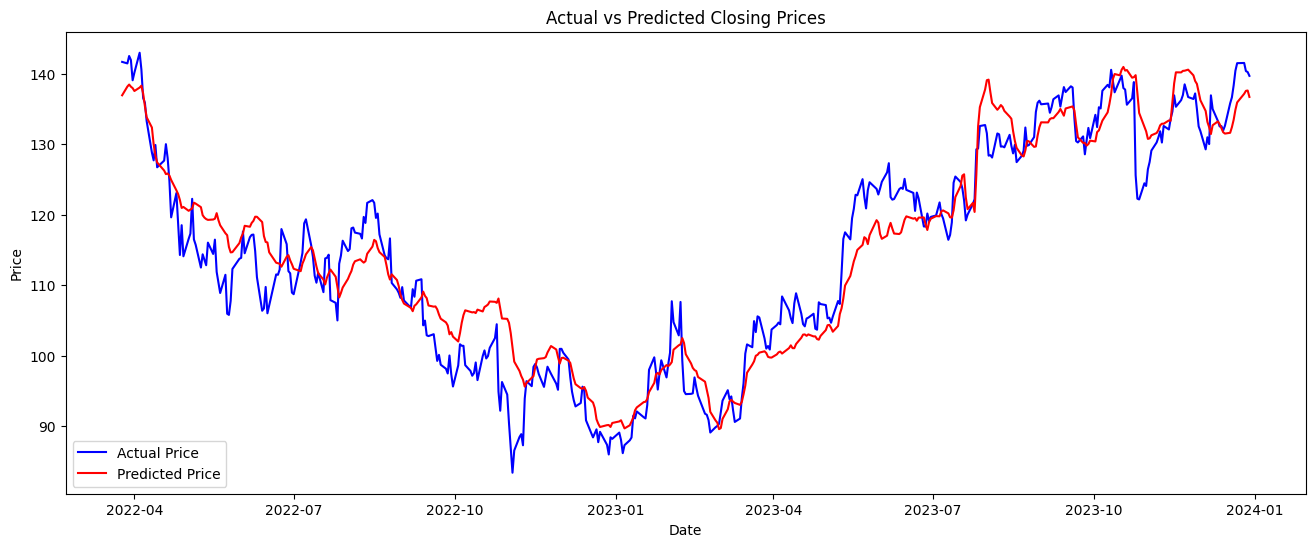

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.plot(test_data.index[seq_length:], test_data['Close'][seq_length:], label='Actual Price', color='blue')
plt.plot(test_data.index[seq_length:], test_predictions_rescaled, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()